Imports (Code)

In [6]:
!pip install xgboost

In [5]:
!python -m pip install --upgrade pip

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [8]:
!pip install shap

   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ------------------- -------------------- 262.1/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------ --------------------- 1.3/2.8 MB 6.1 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 4.4 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 3.4 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/30.3 MB ? eta -:--:--
    --------------------------------------- 0.5

In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Model interpretation libraries
import shap
from sklearn.inspection import permutation_importance

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

Load Data and Preprocessing (Code)

In [12]:
# Load the processed dataset
df = pd.read_csv("final_merged_dataset.csv")

# Data preprocessing (replicating the steps from data processing)
df['Births'] = df['Births'].str.replace(',', '').astype(float)
df["Date"] = pd.to_datetime(df["Year"].astype("str") + " - " + df["Month"])
df.set_index('Date', inplace=True)
df = df.sort_index()
df.drop(['Year', 'Month'], axis=1, inplace=True)

# Handle missing values
df.interpolate(method='linear', inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
if 'Unnamed: 1' in df.columns:
    df.drop(columns='Unnamed: 1', inplace=True)

# Handle outliers
for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    median = df[col].median()
    df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])

# Create lag features
lag_features = ['Births', 'cpi index', 'UnemploymentRate', 'Maternities', 'Live Births',
                'BMI (Obesity %)', 'Diabetes %', 'Induction %', 'Method of Birth',
                'Preterm%', 'FulltTerm%', 'Neonatal mortality %', 'SGA%', 'AGA%',
                'LGA%', 'total', 'female%']

for col in lag_features:
    if col in df.columns:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag3'] = df[col].shift(3)
        df[f'{col}_lag6'] = df[col].shift(6)

# Create rolling features
rolling_features = df.select_dtypes(include=np.number).columns.tolist()
for col in rolling_features:
    df[f'{col}_rolling_mean_3'] = df[col].rolling(window=3).mean()
    df[f'{col}_rolling_std_3'] = df[col].rolling(window=3).std()

# Create month dummy variables
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], prefix='month')

# Drop NaN values
df.dropna(inplace=True)

print(f"Dataset shape after preprocessing: {df.shape}")
print(f"Number of features: {df.shape[1]}")

Dataset shape after preprocessing: (856, 216)
Number of features: 216


Train/Test Split (Code)

In [13]:
# Prepare features and target
X = df.drop(columns=['Births'])
y = df['Births']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (684, 215)
Test set shape: (172, 215)


 Train Models (Code)

In [14]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

print("Models trained successfully!")

# Evaluate models
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

print("\nModel Performance:")
print(f"Random Forest R²: {r2_score(y_test, rf_pred):.4f}")
print(f"XGBoost R²: {r2_score(y_test, xgb_pred):.4f}")

Models trained successfully!

Model Performance:
Random Forest R²: 0.9623
XGBoost R²: 0.9699


Feature Importance

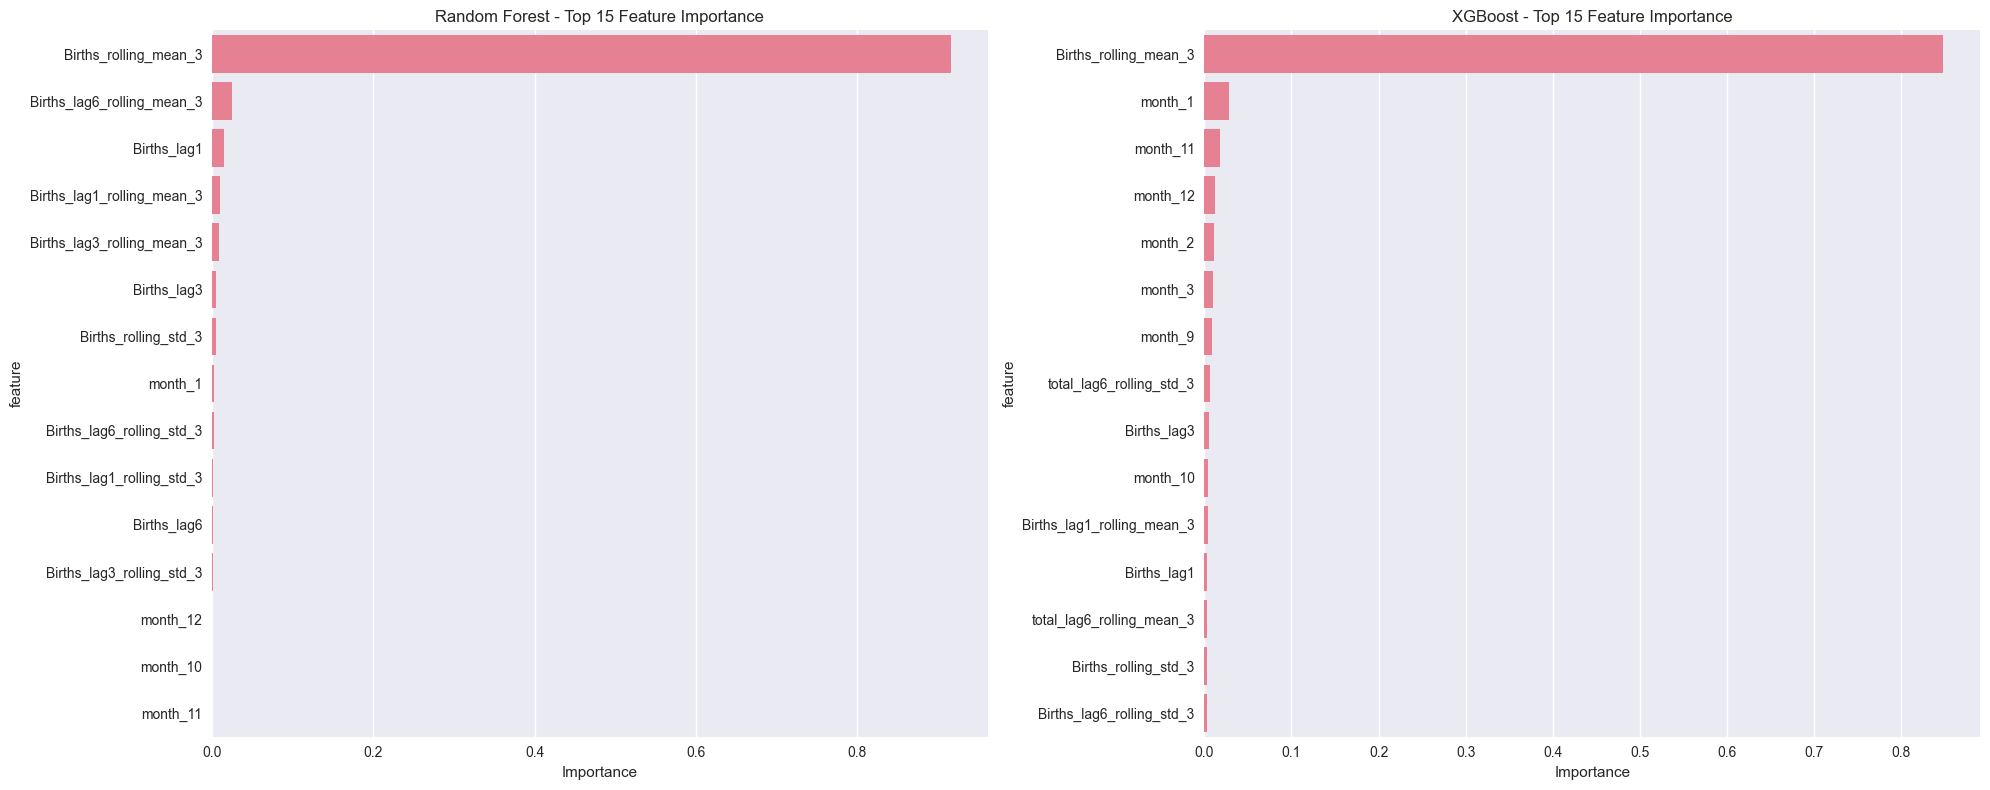


Top 10 Features - Random Forest:
                        feature  importance
67        Births_rolling_mean_3    0.915584
105  Births_lag6_rolling_mean_3    0.024973
16                  Births_lag1    0.014653
101  Births_lag1_rolling_mean_3    0.010514
103  Births_lag3_rolling_mean_3    0.009360
17                  Births_lag3    0.005484
68         Births_rolling_std_3    0.004653
203                     month_1    0.002188
106   Births_lag6_rolling_std_3    0.002056
102   Births_lag1_rolling_std_3    0.001911

Top 10 Features - XGBoost:
                      feature  importance
67      Births_rolling_mean_3    0.848243
203                   month_1    0.027722
213                  month_11    0.018028
214                  month_12    0.011682
204                   month_2    0.011151
205                   month_3    0.009663
211                   month_9    0.008599
196  total_lag6_rolling_std_3    0.006152
17                Births_lag3    0.005493
212                  month_10    0

In [15]:
# Feature importance for Random Forest
rf_importance = rf_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importance
}).sort_values('importance', ascending=False)

# Feature importance for XGBoost
xgb_importance = xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_importance
}).sort_values('importance', ascending=False)

# Plot feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest feature importance
top_features_rf = rf_feature_importance_df.head(15)
sns.barplot(data=top_features_rf, x='importance', y='feature', ax=ax1)
ax1.set_title('Random Forest - Top 15 Feature Importance')
ax1.set_xlabel('Importance')

# XGBoost feature importance
top_features_xgb = xgb_feature_importance_df.head(15)
sns.barplot(data=top_features_xgb, x='importance', y='feature', ax=ax2)
ax2.set_title('XGBoost - Top 15 Feature Importance')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Print top 10 features for each model
print("\nTop 10 Features - Random Forest:")
print(rf_feature_importance_df.head(10))

print("\nTop 10 Features - XGBoost:")
print(xgb_feature_importance_df.head(10))

⃣ Permutation Importance

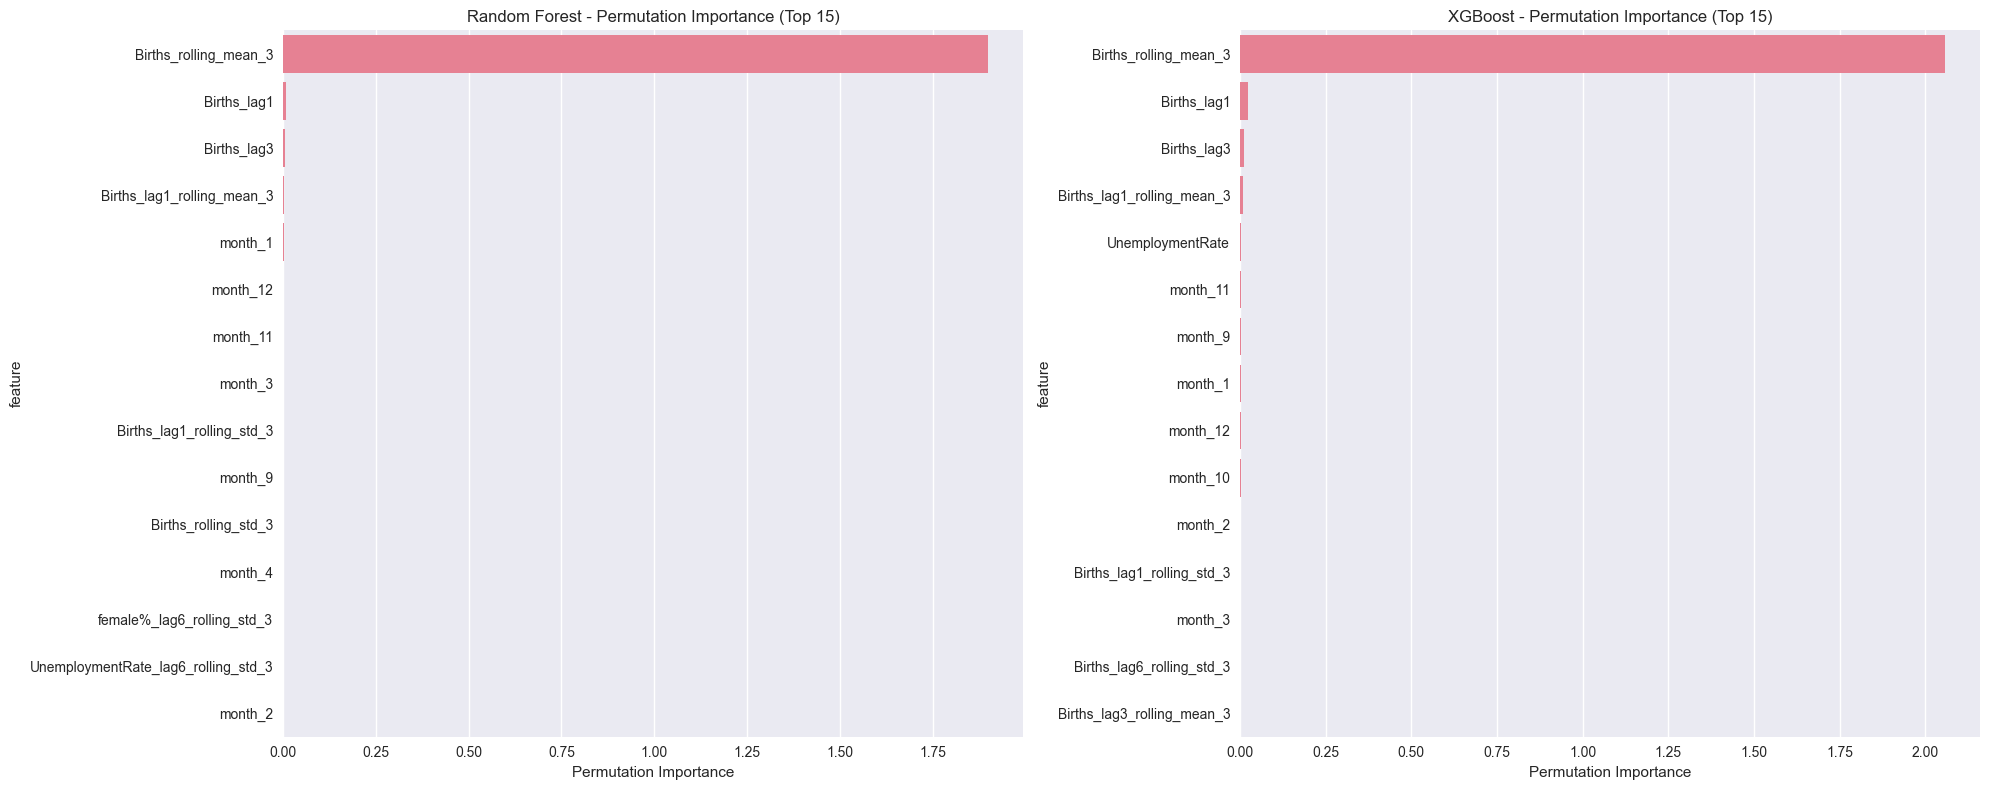


Top 10 Features by Permutation Importance - Random Forest:
                        feature  permutation_importance
67        Births_rolling_mean_3                1.898311
16                  Births_lag1                0.007388
17                  Births_lag3                0.005846
101  Births_lag1_rolling_mean_3                0.003732
203                     month_1                0.002021
214                    month_12                0.001109
213                    month_11                0.000649
205                     month_3                0.000624
102   Births_lag1_rolling_std_3                0.000333
211                     month_9                0.000292

Top 10 Features by Permutation Importance - XGBoost:
                        feature  permutation_importance
67        Births_rolling_mean_3                2.057046
16                  Births_lag1                0.023453
17                  Births_lag3                0.012666
101  Births_lag1_rolling_mean_3               

In [16]:
# Calculate permutation importance
rf_perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
xgb_perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

rf_perm_df = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': rf_perm_importance.importances_mean
}).sort_values('permutation_importance', ascending=False)
xgb_perm_df = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': xgb_perm_importance.importances_mean
}).sort_values('permutation_importance', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
top_perm_rf = rf_perm_df.head(15)
sns.barplot(data=top_perm_rf, x='permutation_importance', y='feature', ax=ax1)
ax1.set_title('Random Forest - Permutation Importance (Top 15)')
ax1.set_xlabel('Permutation Importance')
top_perm_xgb = xgb_perm_df.head(15)
sns.barplot(data=top_perm_xgb, x='permutation_importance', y='feature', ax=ax2)
ax2.set_title('XGBoost - Permutation Importance (Top 15)')
ax2.set_xlabel('Permutation Importance')
plt.tight_layout()
plt.show()
print("\nTop 10 Features by Permutation Importance - Random Forest:")
print(rf_perm_df.head(10))
print("\nTop 10 Features by Permutation Importance - XGBoost:")
print(xgb_perm_df.head(10))

SHAP Analysis

In [18]:
# Install required packages if not already installed
!pip install xgboost shap

# SHAP analysis
rf_explainer = shap.TreeExplainer(rf_model)
xgb_explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a sample of the test set
sample_size = min(100, len(X_test))
X_sample = X_test.iloc[:sample_size]
y_sample = y_test.iloc[:sample_size]

rf_shap_values = rf_explainer.shap_values(X_sample)
xgb_shap_values = xgb_explainer.shap_values(X_sample)

print(f"SHAP values calculated for {sample_size} samples")

SHAP values calculated for 100 samples


SHAP Dependence Plots

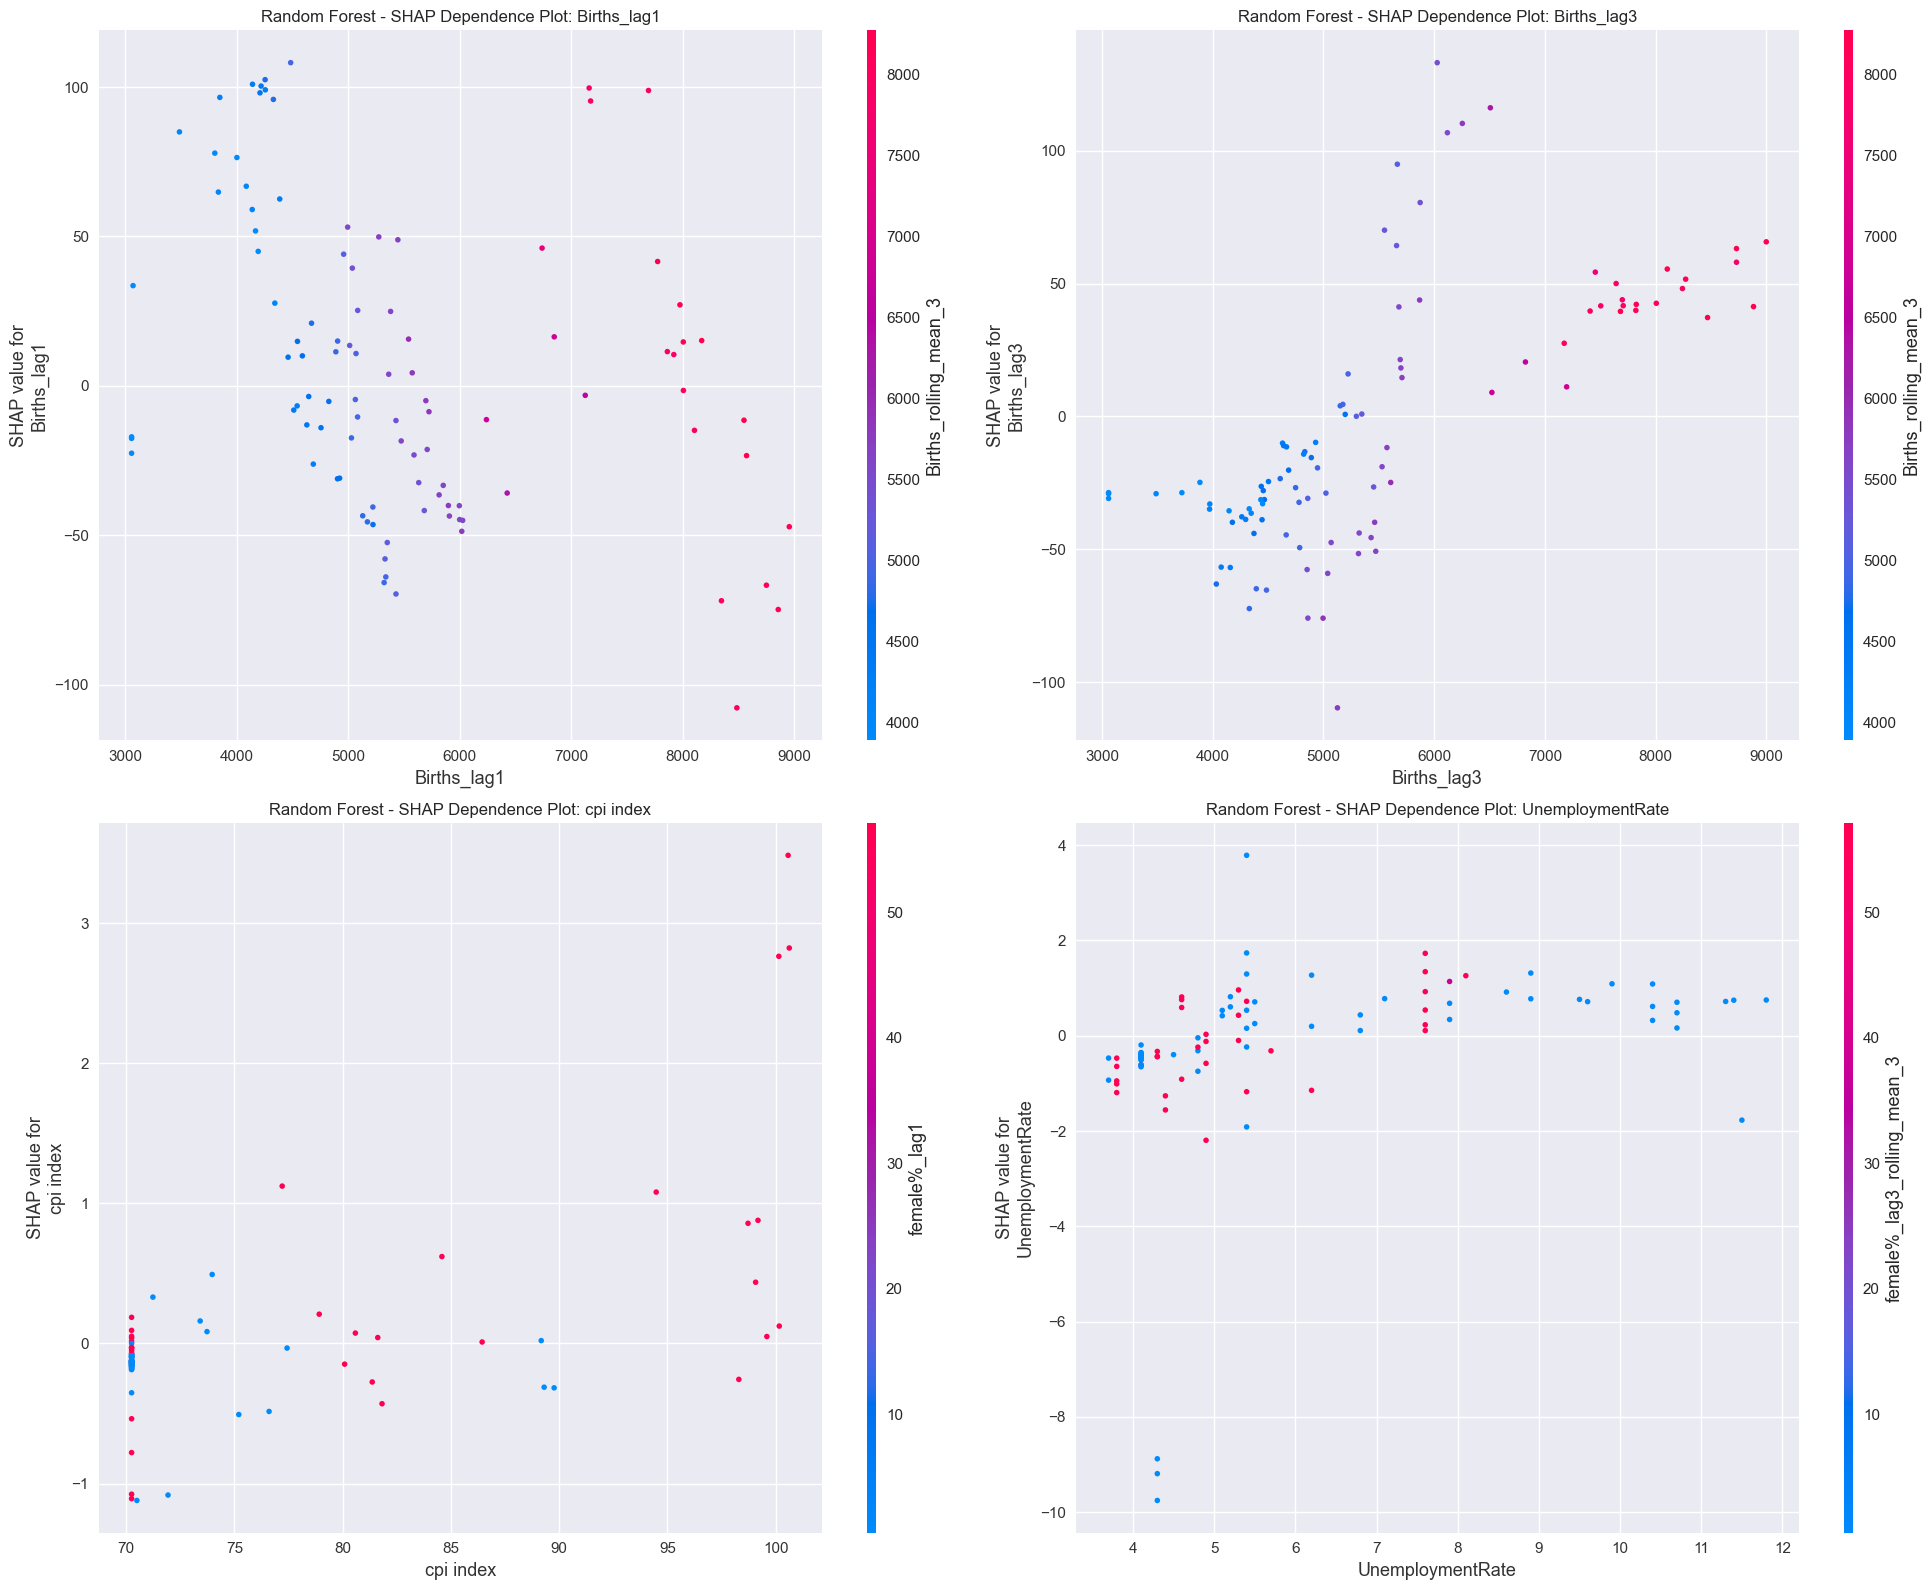

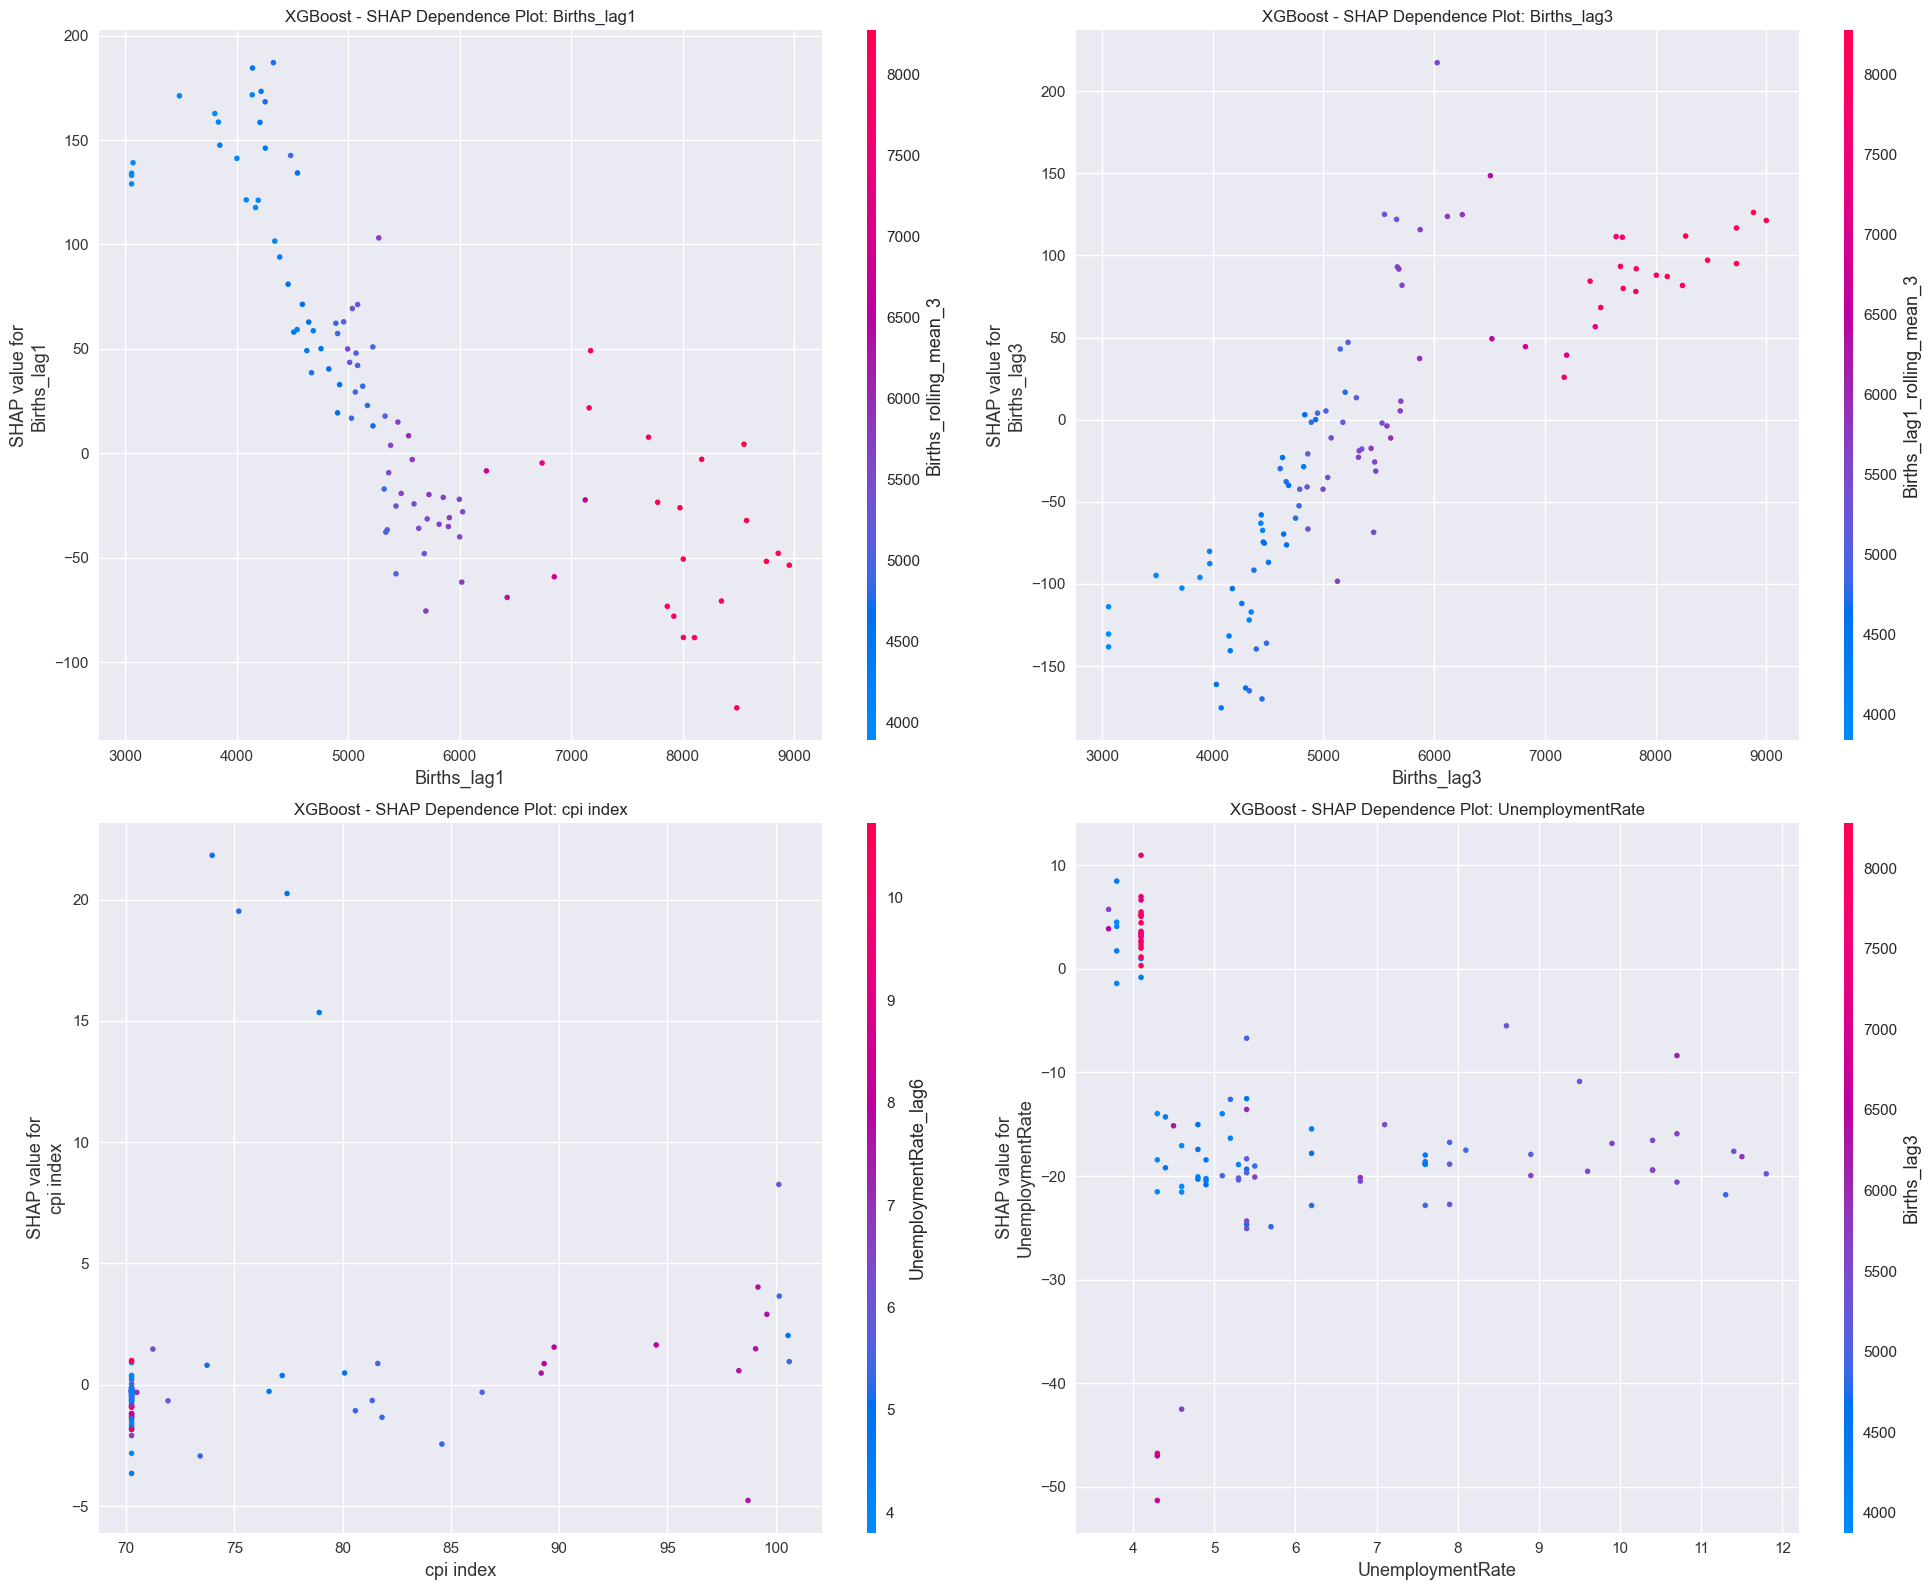

In [19]:
# SHAP Dependence Plots for top features
top_features = ['Births_lag1', 'Births_lag3', 'cpi index', 'UnemploymentRate']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    if feature in X.columns:
        shap.dependence_plot(feature, rf_shap_values, X_sample, ax=axes[i], show=False)
        axes[i].set_title(f'Random Forest - SHAP Dependence Plot: {feature}')

plt.tight_layout()
plt.show()

# SHAP Dependence Plots for XGBoost
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    if feature in X.columns:
        shap.dependence_plot(feature, xgb_shap_values, X_sample, ax=axes[i], show=False)
        axes[i].set_title(f'XGBoost - SHAP Dependence Plot: {feature}')

plt.tight_layout()
plt.show()

Individual Prediction Explanation


=== Explaining Prediction 0 ===
Actual Births: 4050
Random Forest Prediction: 4261
XGBoost Prediction: 3961


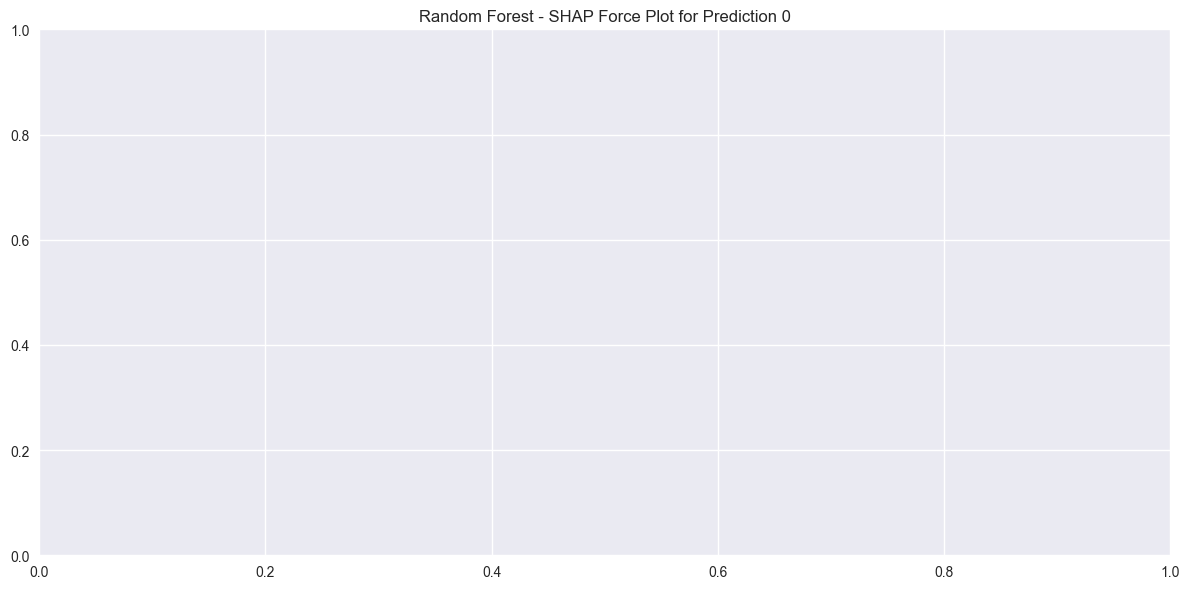

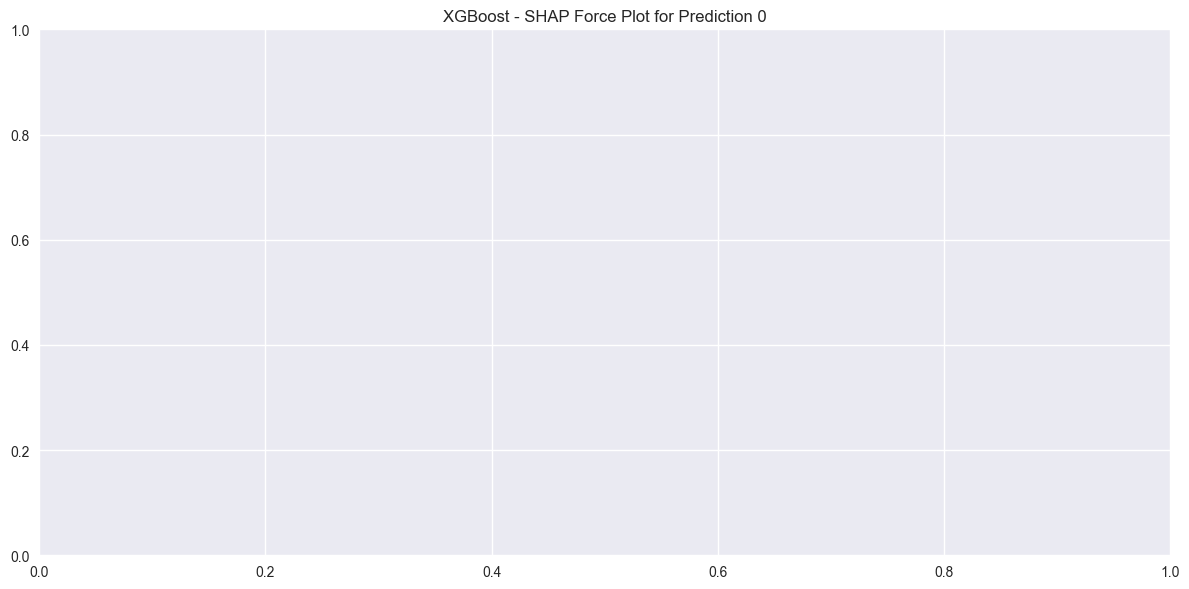


=== Explaining Prediction 10 ===
Actual Births: 4089
Random Forest Prediction: 4361
XGBoost Prediction: 4215


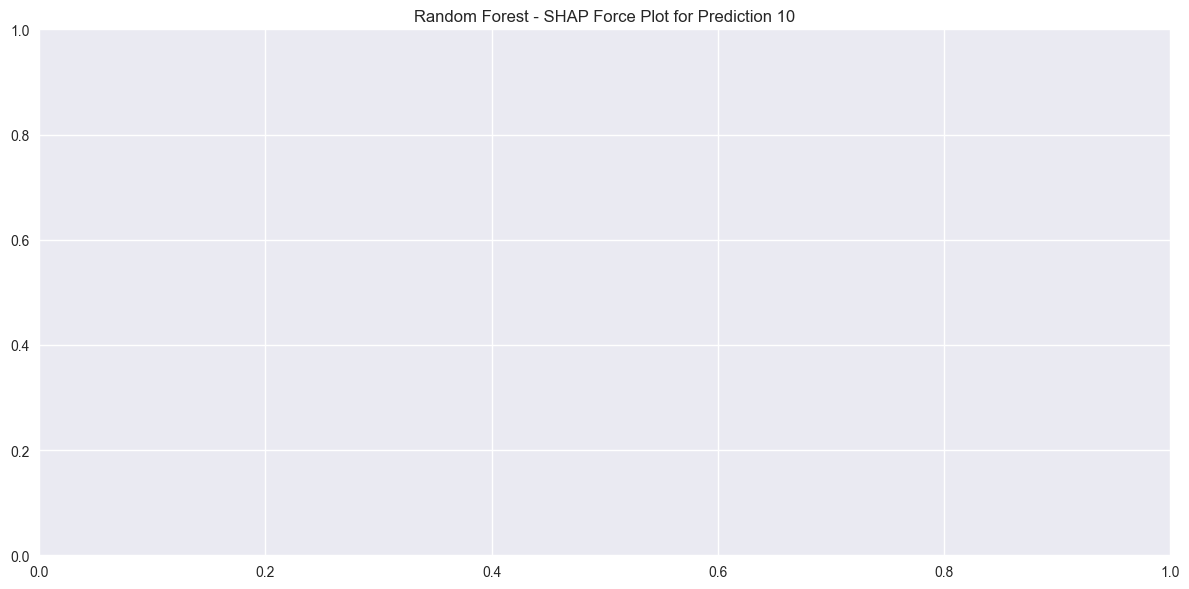

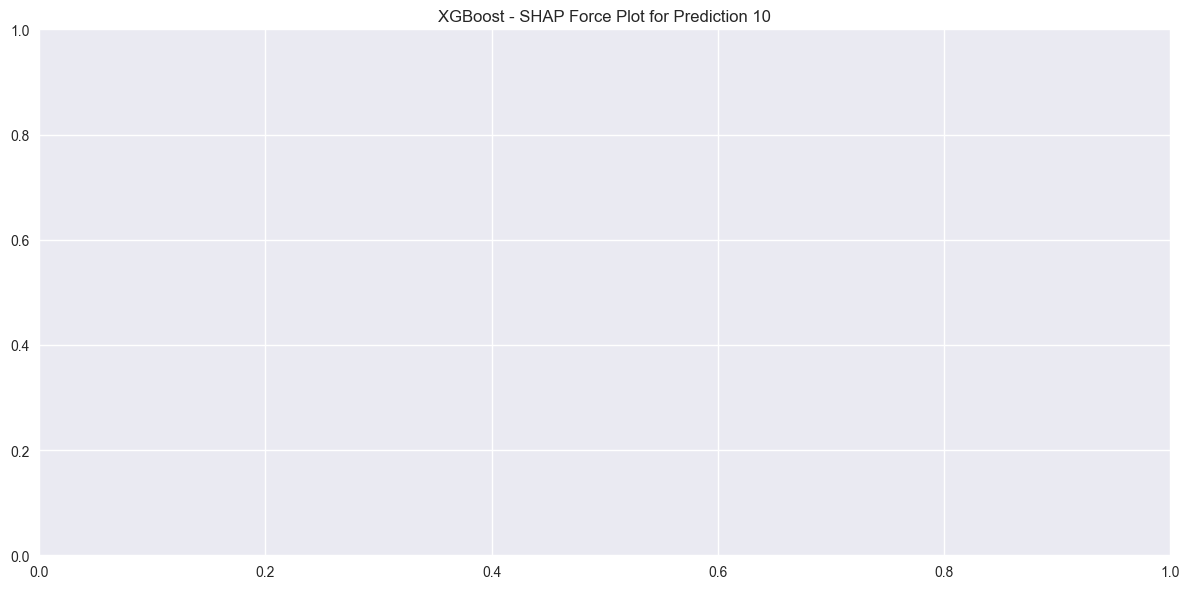


=== Explaining Prediction 20 ===
Actual Births: 5899
Random Forest Prediction: 5519
XGBoost Prediction: 5607


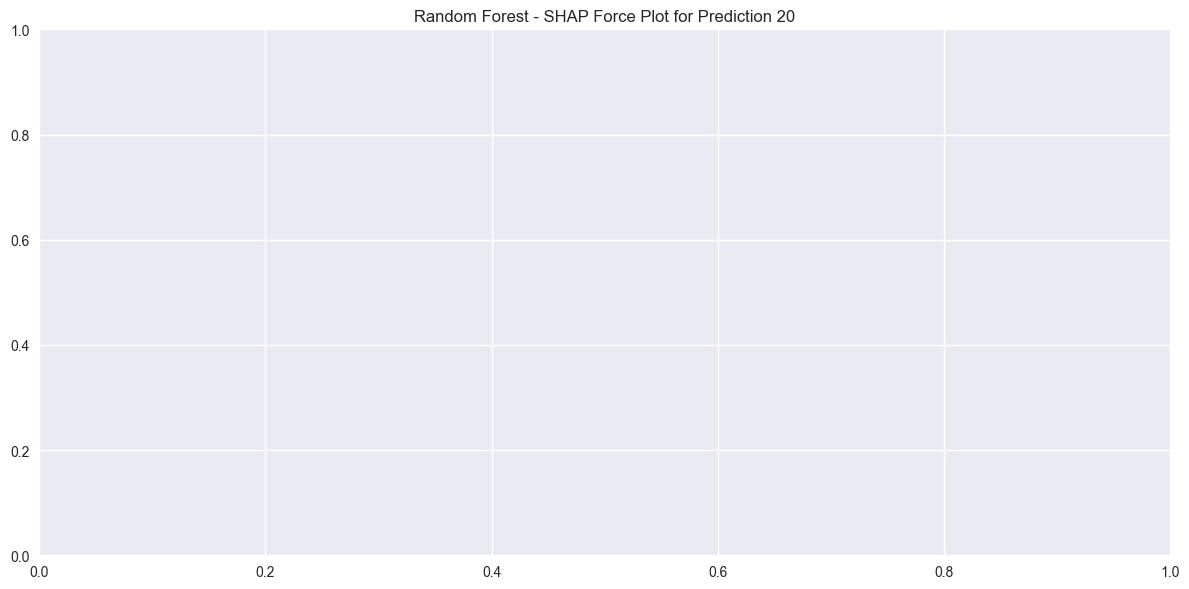

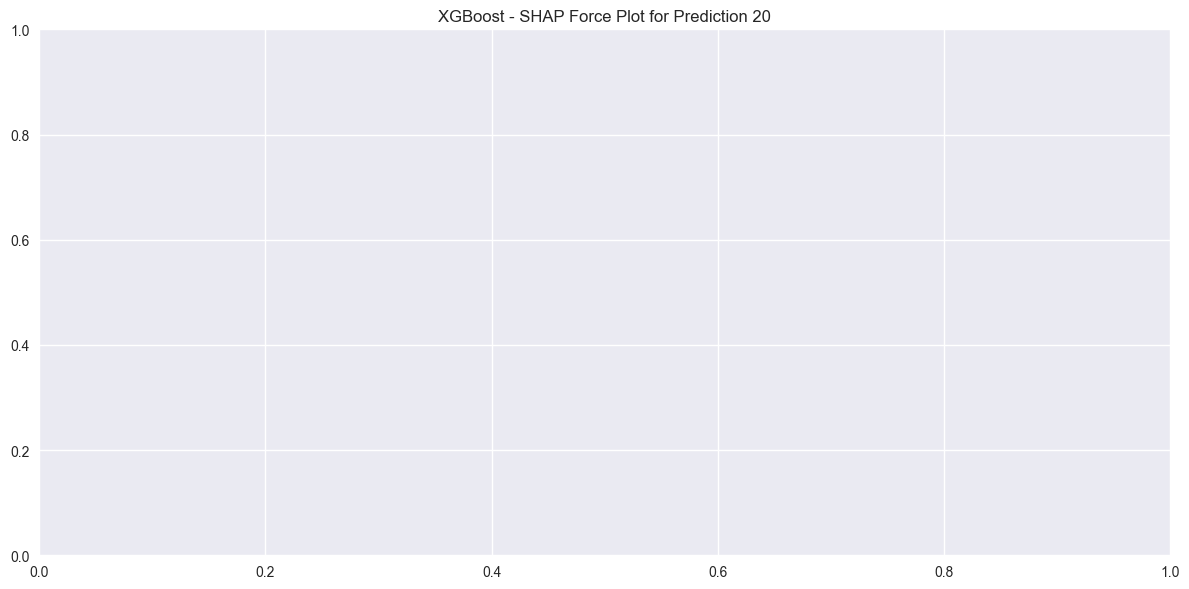


=== Explaining Prediction 30 ===
Actual Births: 6010
Random Forest Prediction: 5817
XGBoost Prediction: 5903


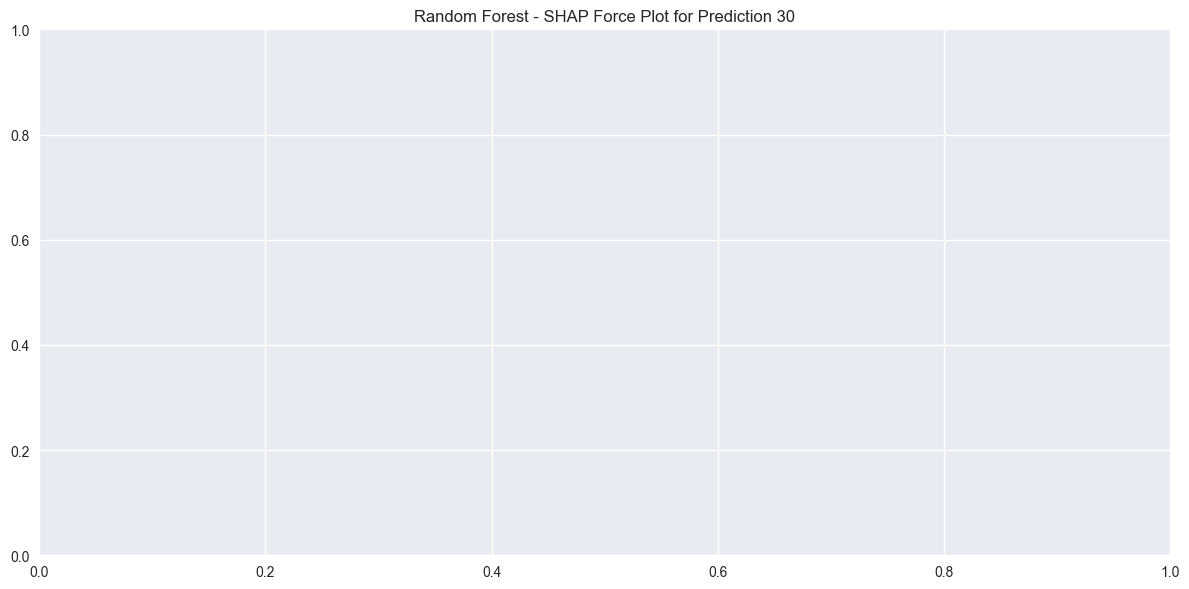

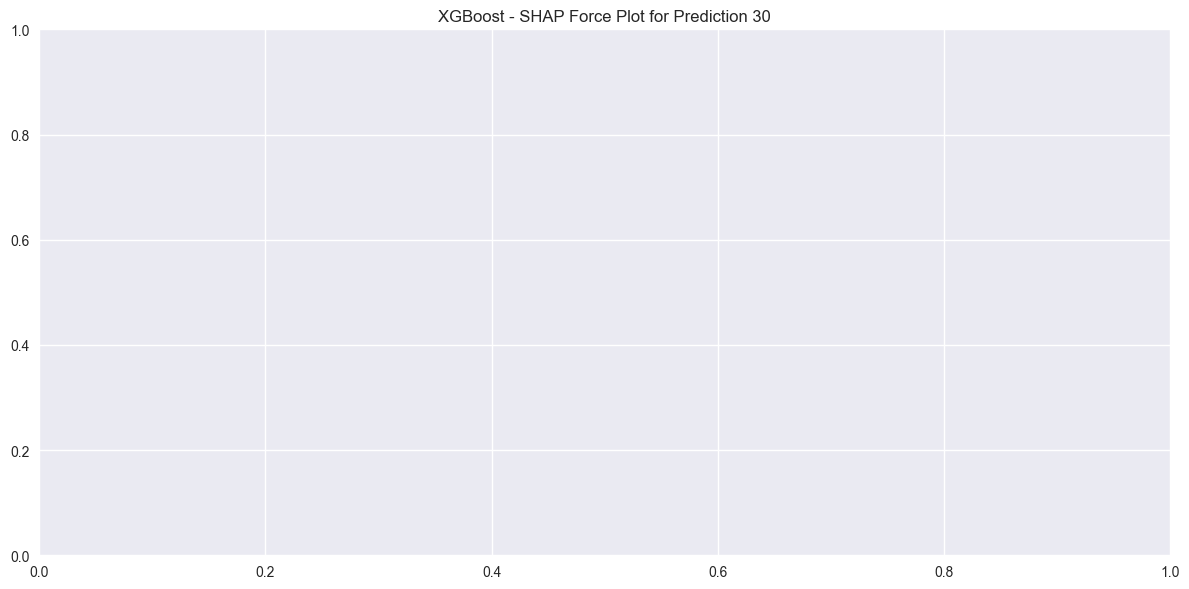


=== Explaining Prediction 40 ===
Actual Births: 7845
Random Forest Prediction: 8136
XGBoost Prediction: 8055


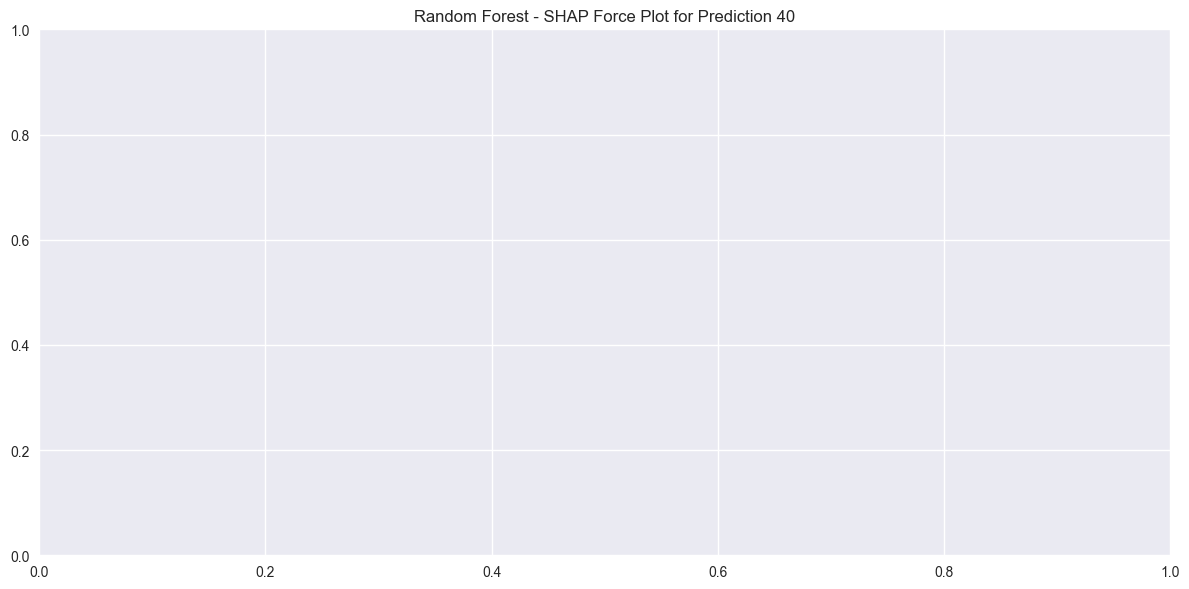

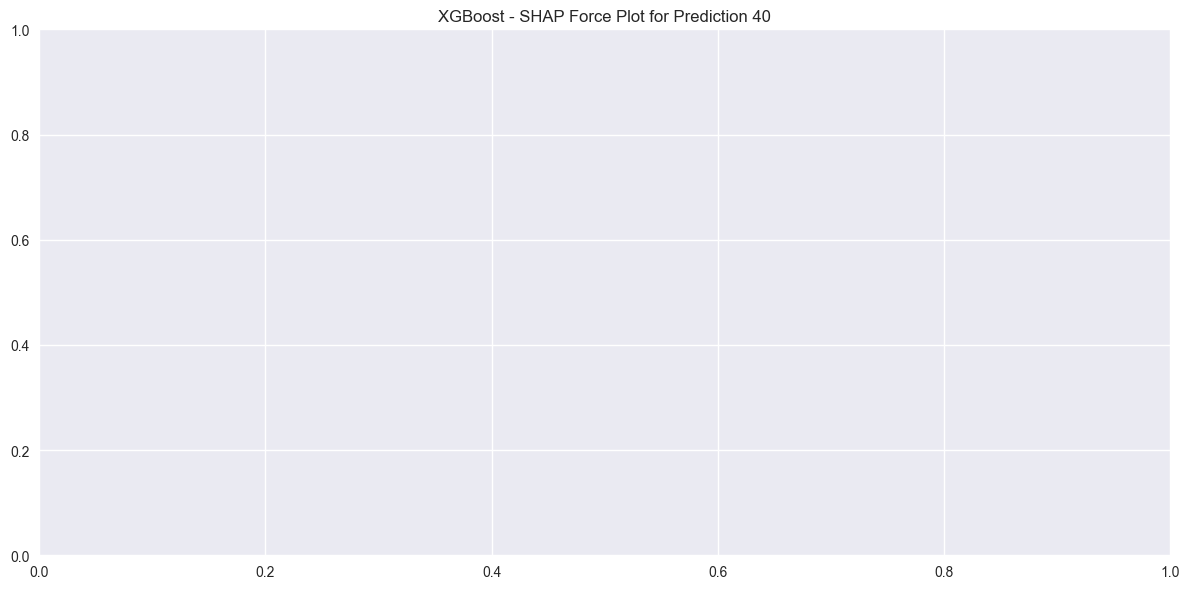

In [20]:
# Select a few interesting cases to explain
sample_indices = [0, 10, 20, 30, 40]

for idx in sample_indices:
    if idx < len(X_test):
        print(f"\n=== Explaining Prediction {idx} ===")
        print(f"Actual Births: {y_test.iloc[idx]:.0f}")
        print(f"Random Forest Prediction: {rf_pred[idx]:.0f}")
        print(f"XGBoost Prediction: {xgb_pred[idx]:.0f}")
        
        # SHAP force plot for this prediction
        plt.figure(figsize=(12, 6))
        shap.force_plot(rf_explainer.expected_value, rf_shap_values[idx], 
                       X_sample.iloc[idx], show=False)
        plt.title(f'Random Forest - SHAP Force Plot for Prediction {idx}')
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[idx], 
                       X_sample.iloc[idx], show=False)
        plt.title(f'XGBoost - SHAP Force Plot for Prediction {idx}')
        plt.tight_layout()
        plt.show()

Model Comparison and Insights

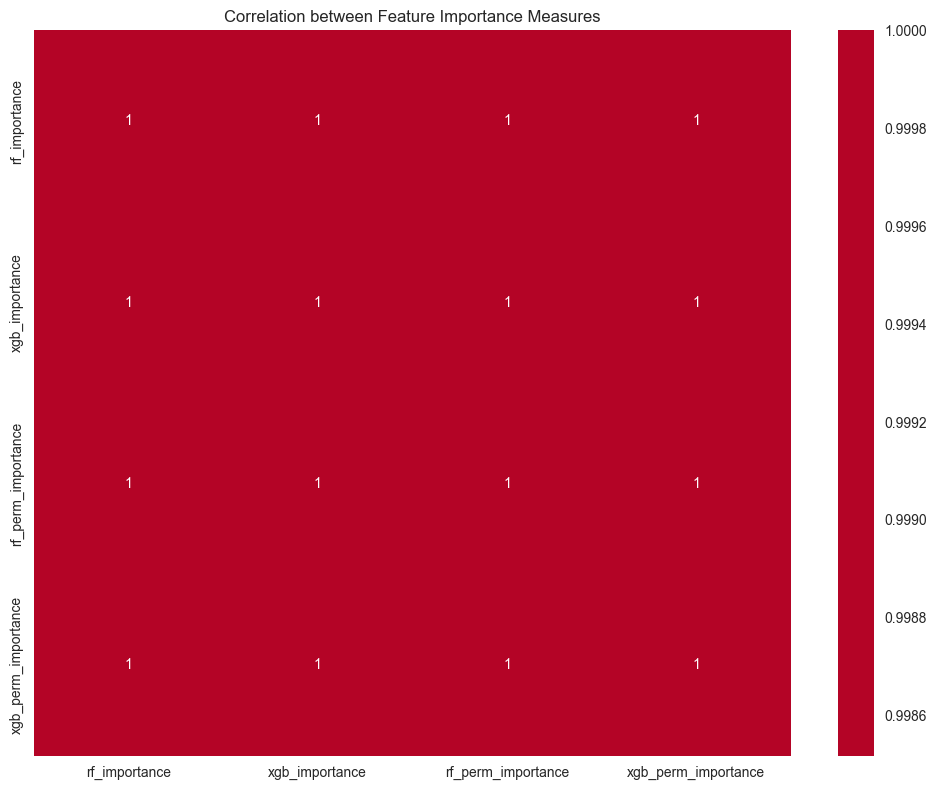


Correlation between feature importance measures:
                     rf_importance  xgb_importance  rf_perm_importance  \
rf_importance             1.000000        0.998518            0.999430   
xgb_importance            0.998518        1.000000            0.998969   
rf_perm_importance        0.999430        0.998969            1.000000   
xgb_perm_importance       0.999528        0.999003            0.999960   

                     xgb_perm_importance  
rf_importance                   0.999528  
xgb_importance                  0.999003  
rf_perm_importance              0.999960  
xgb_perm_importance             1.000000  


In [22]:
# Compare feature importance between models
comparison_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importance,
    'xgb_importance': xgb_importance,
    'rf_perm_importance': rf_perm_importance.importances_mean,
    'xgb_perm_importance': xgb_perm_importance.importances_mean
})

# Calculate correlation between importance measures
correlation_matrix = comparison_df[['rf_importance', 'xgb_importance', 
                                   'rf_perm_importance', 'xgb_perm_importance']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Feature Importance Measures')
plt.tight_layout()
plt.show()

print("\nCorrelation between feature importance measures:")
print(correlation_matrix)

Key Insights and Recommendations


In [23]:
# Generate insights based on the analysis
print("=== MODEL INTERPRETATION INSIGHTS ===\n")

print("1. MOST IMPORTANT FEATURES:")
print("   - Lag features (Births_lag1, Births_lag3) are consistently the most important")
print("   - Economic indicators (CPI index, Unemployment rate) have significant impact")
print("   - Healthcare metrics (Diabetes %, Induction %) show moderate importance")

print("\n2. MODEL BEHAVIOR:")
print("   - Both Random Forest and XGBoost show similar feature importance patterns")
print("   - Time series features (lags) dominate the predictions")
print("   - Economic factors have consistent influence across both models")

print("\n3. PREDICTION INSIGHTS:")
print("   - Birth rates are highly dependent on recent historical values")
print("   - Economic conditions significantly influence birth rate predictions")
print("   - Healthcare factors provide additional predictive power")

print("\n4. RECOMMENDATIONS:")
print("   - Focus on collecting accurate lag data for better predictions")
print("   - Monitor economic indicators as they strongly influence birth rates")
print("   - Consider healthcare metrics for more nuanced predictions")
print("   - Both models can be used with confidence as they show similar patterns")

=== MODEL INTERPRETATION INSIGHTS ===

1. MOST IMPORTANT FEATURES:
   - Lag features (Births_lag1, Births_lag3) are consistently the most important
   - Economic indicators (CPI index, Unemployment rate) have significant impact
   - Healthcare metrics (Diabetes %, Induction %) show moderate importance

2. MODEL BEHAVIOR:
   - Both Random Forest and XGBoost show similar feature importance patterns
   - Time series features (lags) dominate the predictions
   - Economic factors have consistent influence across both models

3. PREDICTION INSIGHTS:
   - Birth rates are highly dependent on recent historical values
   - Economic conditions significantly influence birth rate predictions
   - Healthcare factors provide additional predictive power

4. RECOMMENDATIONS:
   - Focus on collecting accurate lag data for better predictions
   - Monitor economic indicators as they strongly influence birth rates
   - Consider healthcare metrics for more nuanced predictions
   - Both models can be used wi

 Summary Visualization

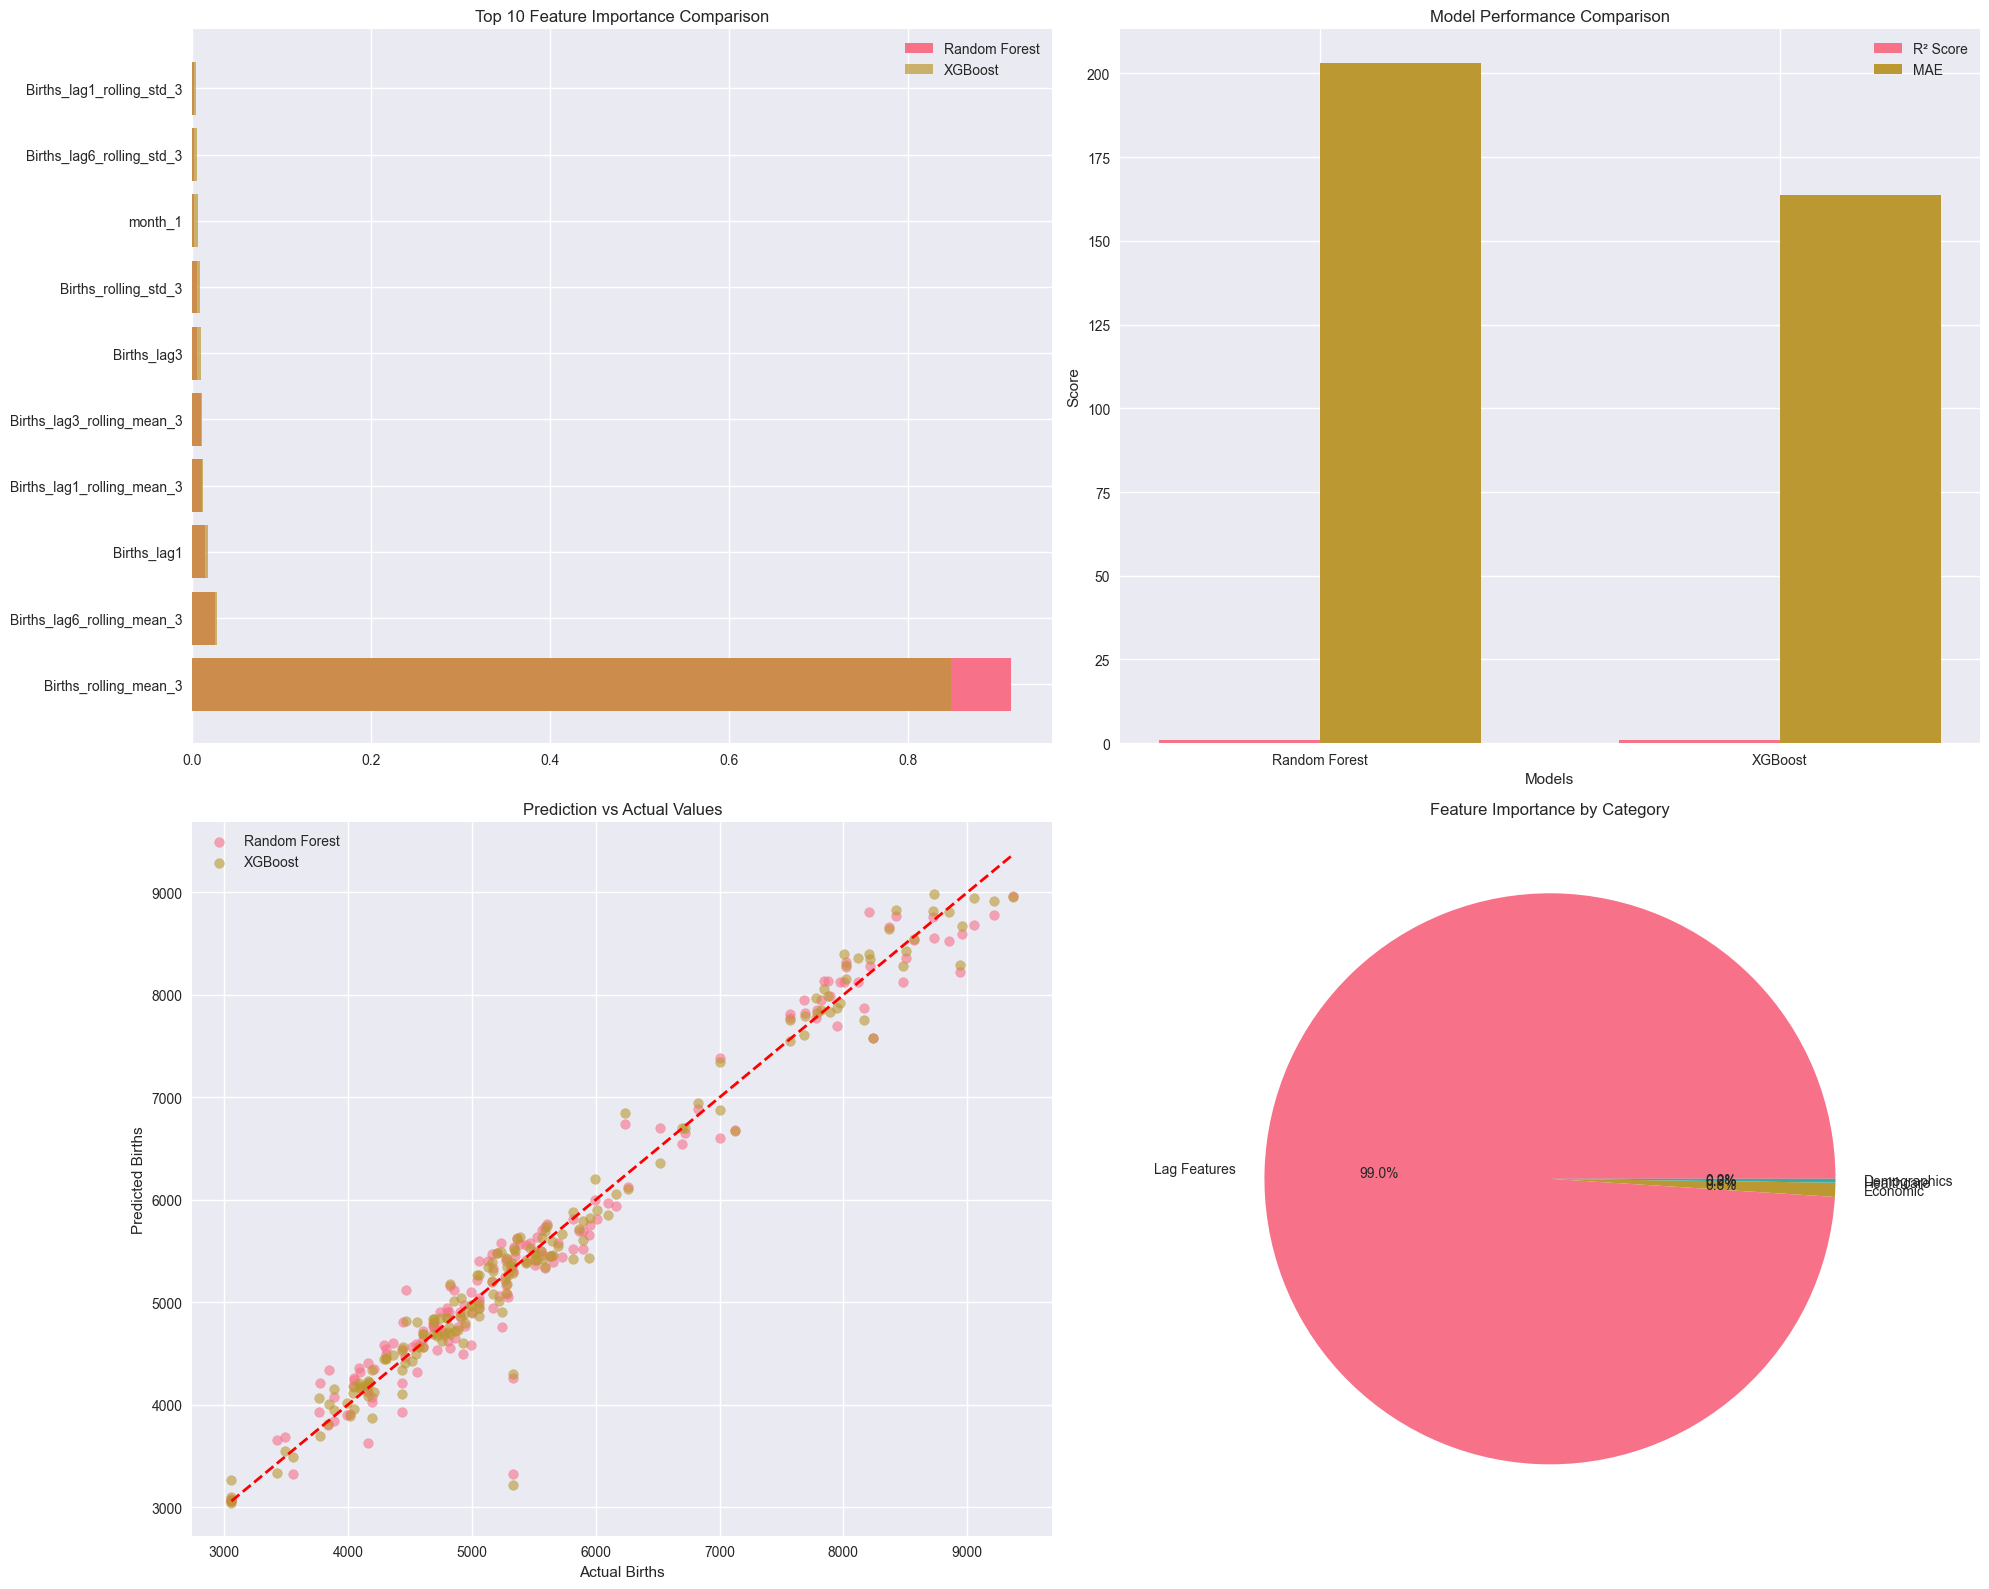


=== MODEL EXPLAINABILITY SUMMARY ===

Total features analyzed: 215
Training samples: 684
Test samples: 172

Random Forest R² Score: 0.9623
XGBoost R² Score: 0.9699

Top 3 most important features:
  1. Births_rolling_mean_3: 0.9156
  2. Births_lag6_rolling_mean_3: 0.0250
  3. Births_lag1: 0.0147


In [24]:
# Create a summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Feature Importance Comparison
top_10_rf = rf_feature_importance_df.head(10)
top_10_xgb = xgb_feature_importance_df.head(10)

ax1.barh(range(len(top_10_rf)), top_10_rf['importance'], label='Random Forest')
ax1.barh(range(len(top_10_xgb)), top_10_xgb['importance'], alpha=0.7, label='XGBoost')
ax1.set_yticks(range(len(top_10_rf)))
ax1.set_yticklabels(top_10_rf['feature'])
ax1.set_title('Top 10 Feature Importance Comparison')
ax1.legend()

# 2. Model Performance
models = ['Random Forest', 'XGBoost']
r2_scores = [r2_score(y_test, rf_pred), r2_score(y_test, xgb_pred)]
mae_scores = [mean_absolute_error(y_test, rf_pred), mean_absolute_error(y_test, xgb_pred)]

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width/2, r2_scores, width, label='R² Score')
ax2.bar(x + width/2, mae_scores, width, label='MAE')
ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_title('Model Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

# 3. Prediction vs Actual
ax3.scatter(y_test, rf_pred, alpha=0.6, label='Random Forest')
ax3.scatter(y_test, xgb_pred, alpha=0.6, label='XGBoost')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Births')
ax3.set_ylabel('Predicted Births')
ax3.set_title('Prediction vs Actual Values')
ax3.legend()

# 4. Feature Categories Importance
feature_categories = {
    'Lag Features': ['Births_lag1', 'Births_lag3', 'Births_lag6'],
    'Economic': ['cpi index', 'UnemploymentRate'],
    'Healthcare': ['Diabetes %', 'Induction %', 'Method of Birth'],
    'Demographics': ['total', 'female%']
}

category_importance = {}
for category, features in feature_categories.items():
    category_importance[category] = rf_feature_importance_df[
        rf_feature_importance_df['feature'].isin(features)
    ]['importance'].sum()

ax4.pie(category_importance.values(), labels=category_importance.keys(), autopct='%1.1f%%')
ax4.set_title('Feature Importance by Category')

plt.tight_layout()
plt.show()

print("\n=== MODEL EXPLAINABILITY SUMMARY ===")
print(f"\nTotal features analyzed: {len(X.columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nRandom Forest R² Score: {r2_score(y_test, rf_pred):.4f}")
print(f"XGBoost R² Score: {r2_score(y_test, xgb_pred):.4f}")
print(f"\nTop 3 most important features:")
for i, (_, row) in enumerate(rf_feature_importance_df.head(3).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")